In [1]:
!ls
%cd ../../..
!pwd
# Now you should see the bubble-segmentation-final-deep-learning directory

detectron2-test.ipynb  detectron2-train.ipynb
/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning
/Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning


In [2]:
import os

END_WITH_LOCAL = 'bubble-segmentation-final-deep-learning'

os.environ['PATH'] = f"/root/.cargo/bin:{os.environ['PATH']}"

BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")

# Simple validation
if not (BASE_DIR.endswith('/content') or BASE_DIR.endswith(END_WITH_LOCAL)):
    raise ValueError(f"Expected to be in .../{END_WITH_LOCAL} or .../content directory, but got: {BASE_DIR}")

BASE_DIR: /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning


In [3]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [4]:
import os
import json
import xml.etree.ElementTree as ET
from tqdm import tqdm
import random

# --- Configuration ---
BASE_PATH = os.path.join(BASE_DIR, "data", "Manga109_released_2023_12_07")  # Adjusted to the new dataset directory
ANNOTATION_DIR = os.path.join(BASE_PATH, "annotations")
CATEGORIES_TO_DETECT = ["body", "frame"]
VAL_SPLIT_RATIO = 0.2  # Use 20% of the data for validation

def process_books(book_list, output_filename):
    """Processes a list of books and saves them to a COCO JSON file."""
    
    # Category mapping (IDs should start from 1)
    categories_coco = [{"id": i, "name": name} for i, name in enumerate(CATEGORIES_TO_DETECT, start=1)]
    category_map = {name: i for i, name in enumerate(CATEGORIES_TO_DETECT, start=1)}
    
    coco_output = {
        "info": {
            "description": "Manga109 Dataset for Detectron2",
            "version": "1.0",
        },
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": categories_coco
    }
    
    annotation_id_counter = 1
    image_id_counter = 1
    
    print(f"Processing {len(book_list)} books for '{output_filename}'...")
    for book in tqdm(book_list, desc=f"Processing for {output_filename}"):
        xml_file_path = os.path.join(ANNOTATION_DIR, f"{book}.xml")
        
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        
        for page in root.findall(".//page"):
            page_index = page.attrib['index']
            image_width = int(page.attrib['width'])
            image_height = int(page.attrib['height'])
            
            image_rel_path = os.path.join(book, f"{page_index.zfill(3)}.jpg")
            
            image_info = {
                "id": image_id_counter,
                "file_name": image_rel_path,
                "width": image_width,
                "height": image_height,
            }
            coco_output["images"].append(image_info)

            for category_name in CATEGORIES_TO_DETECT:
                for obj in page.findall(category_name):
                    bbox = obj.attrib
                    xmin = int(bbox['xmin'])
                    ymin = int(bbox['ymin'])
                    width = int(bbox['xmax']) - xmin
                    height = int(bbox['ymax']) - ymin
                    
                    annotation_info = {
                        "id": annotation_id_counter,
                        "image_id": image_id_counter,
                        "category_id": category_map[category_name],
                        "bbox": [xmin, ymin, width, height],
                        "area": width * height,
                        "iscrowd": 0,
                    }
                    coco_output["annotations"].append(annotation_info)
                    annotation_id_counter += 1
            
            image_id_counter += 1

    output_json_path = os.path.join(BASE_PATH, output_filename)
    with open(output_json_path, 'w') as f:
        json.dump(coco_output, f)
        
    print(f"\nConversion complete! File saved to: {output_json_path}")
    return output_json_path

SEED = 42
random.seed(SEED)

if __name__ == '__main__':
    all_books = [f.replace('.xml', '') for f in os.listdir(ANNOTATION_DIR) if f.endswith('.xml')]
    random.shuffle(all_books) # Shuffle for a random split

    split_index = int(len(all_books) * VAL_SPLIT_RATIO)
    val_books = all_books[:split_index]
    train_books = all_books[split_index:]
    
    print(f"Total books: {len(all_books)}. Training books: {len(train_books)}. Validation books: {len(val_books)}.")

    # Process and save the training and validation sets
    process_books(train_books, "train.json")
    process_books(val_books, "val.json")

Total books: 109. Training books: 88. Validation books: 21.
Processing 88 books for 'train.json'...


Processing for train.json: 100%|██████████| 88/88 [00:01<00:00, 73.11it/s]



Conversion complete! File saved to: /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/data/Manga109_released_2023_12_07/train.json
Processing 21 books for 'val.json'...


Processing for val.json: 100%|██████████| 21/21 [00:00<00:00, 84.85it/s]



Conversion complete! File saved to: /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/data/Manga109_released_2023_12_07/val.json


In [5]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
import random
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

# --- Paths ---
BASE_PATH = os.path.join(BASE_DIR, "data", "Manga109_released_2023_12_07")  # Adjusted to the new dataset directory
IMAGE_DIR = os.path.join(BASE_PATH, "images")
TRAIN_JSON_PATH = os.path.join(BASE_PATH, "train.json")
VAL_JSON_PATH = os.path.join(BASE_PATH, "val.json")
CATEGORIES_TO_DETECT = ["body", "frame"]

# --- Register the dataset ---
# The first argument is the name you will use to refer to this dataset.
# Register the training dataset
register_coco_instances("manga109_train", {}, TRAIN_JSON_PATH, IMAGE_DIR)

# Register the validation dataset
register_coco_instances("manga109_val", {}, VAL_JSON_PATH, IMAGE_DIR)

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg

# --- Configuration Setup ---
cfg = get_cfg()

# Start with a pre-trained model. Faster R-CNN is a good choice.
# Find more models in the Detectron2 Model Zoo: https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# cfg.MODEL.WEIGHTS = os.path.join(BASE_DIR, "models/bubble-detection/detectron2/model_final_280758.pkl")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.DEVICE = str(device)

# --- Dataset Configuration ---
cfg.DATASETS.TRAIN = ("manga109_train",)
# --- ADD THE TEST DATASET ---
cfg.DATASETS.TEST = ("manga109_val",) 
# ----------------------------

# --- Evaluation Configuration ---
# How often to run evaluation (in number of iterations).
cfg.TEST.EVAL_PERIOD = 50  # default 500
# --------------------------------

cfg.DATALOADER.NUM_WORKERS = 2 # 12
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # body, frame

cfg.SOLVER.IMS_PER_BATCH = 2 # 8
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 100 # default 3000 
cfg.SOLVER.STEPS = []

cfg.OUTPUT_DIR = os.path.join(BASE_DIR, "models", "bubble-detection","detectron2")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# --- Start Training ---
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'


[11/04 21:47:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_

[11/04 21:47:12 d2.engine.train_loop]: Starting training from iteration 0


An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Volumes/HP_P900/Users/tungnguyen/miniforge3/envs/py11/lib/python3.11/site-packages/iopath/common/event_logger.py", line 97, in log_event

[11/04 21:47:51 d2.utils.events]:  eta: 0:02:06  iter: 19  total_loss: 1.941  loss_cls: 0.884  loss_box_reg: 0.8559  loss_rpn_cls: 0.1203  loss_rpn_loc: 0.1426  time: 1.6118  data_time: 0.1255  lr: 0.00047703  
[11/04 21:48:21 d2.utils.events]:  eta: 0:01:29  iter: 39  total_loss: 1.752  loss_cls: 0.635  loss_box_reg: 0.8704  loss_rpn_cls: 0.07791  loss_rpn_loc: 0.1283  time: 1.5461  data_time: 0.0009  lr: 0.00097653  
[11/04 21:48:37 d2.data.datasets.coco]: Loaded 1955 images in COCO format from /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/data/Manga109_released_2023_12_07/val.json
[11/04 21:48:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/04 21:48:37 d2.data.common]: Serializing 1955 elements to byte tensors and concatenating them all ...

In [8]:
# Add this cell to see what checkpoint files exist
import os
checkpoint_dir = os.path.join(BASE_DIR, "models", "bubble-detection", "detectron2")
print(f"Files in {checkpoint_dir}:")
for f in os.listdir(checkpoint_dir):
    print(f"  {f}")

Files in /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/models/bubble-detection/detectron2:
  metrics.json
  events.out.tfevents.1762267632.backupaccounts-Mac-mini.local.66954.0
  events.out.tfevents.1762267336.backupaccounts-Mac-mini.local.66780.0
  last_checkpoint
  events.out.tfevents.1762267455.backupaccounts-Mac-mini.local.66842.0
  model_final.pth


[11/04 21:51:19 d2.data.datasets.coco]: Loaded 1955 images in COCO format from /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/data/Manga109_released_2023_12_07/val.json


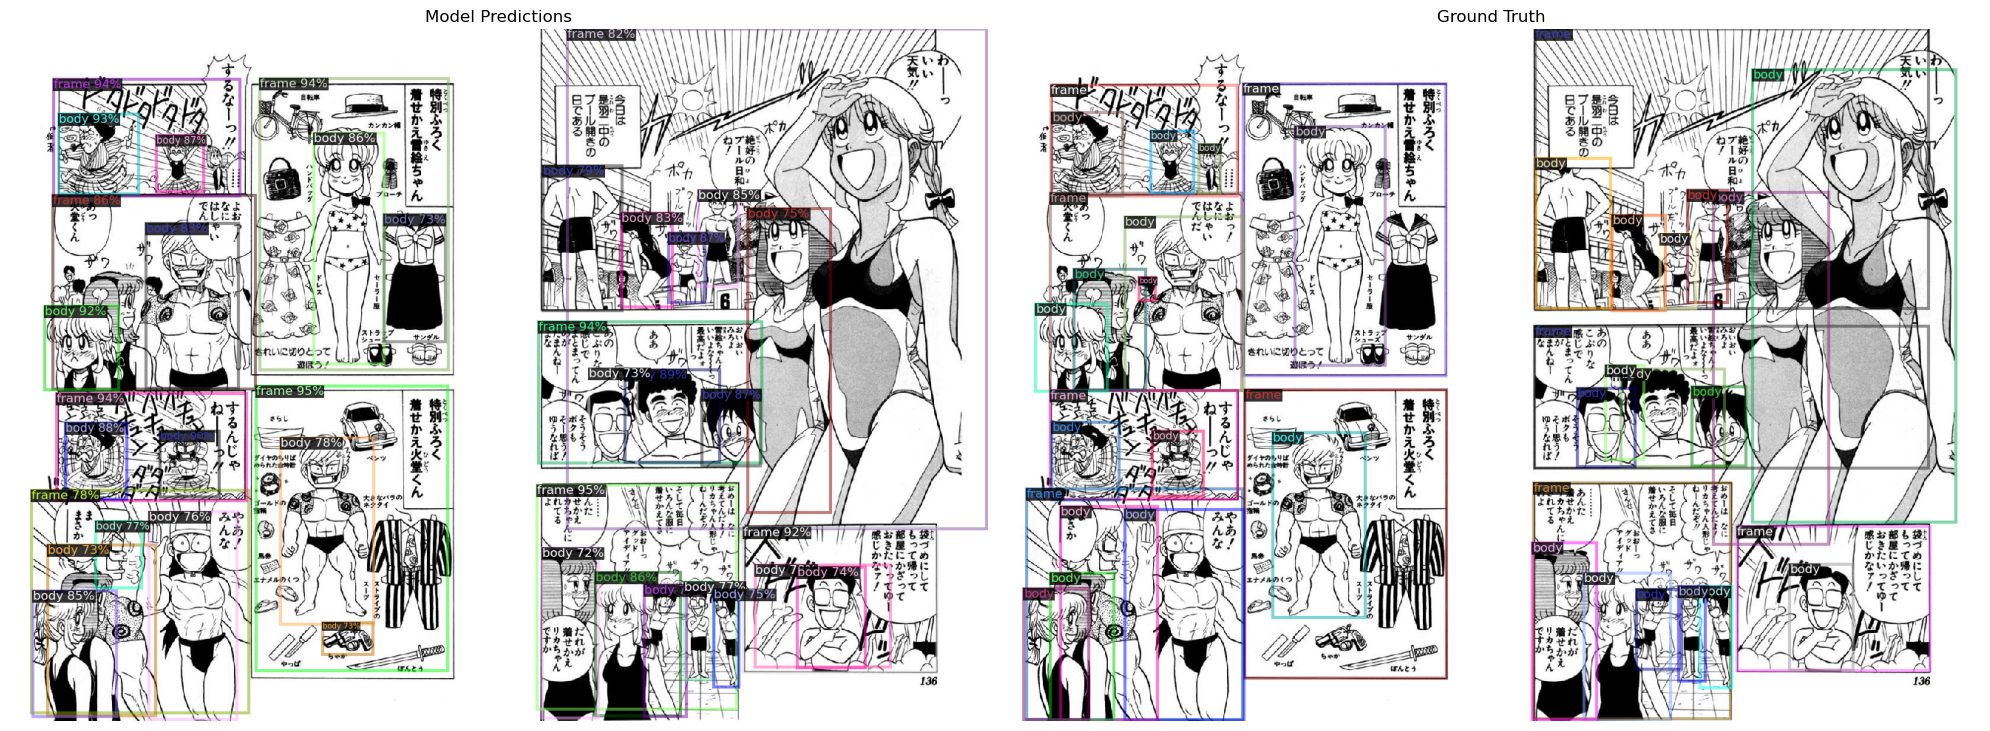

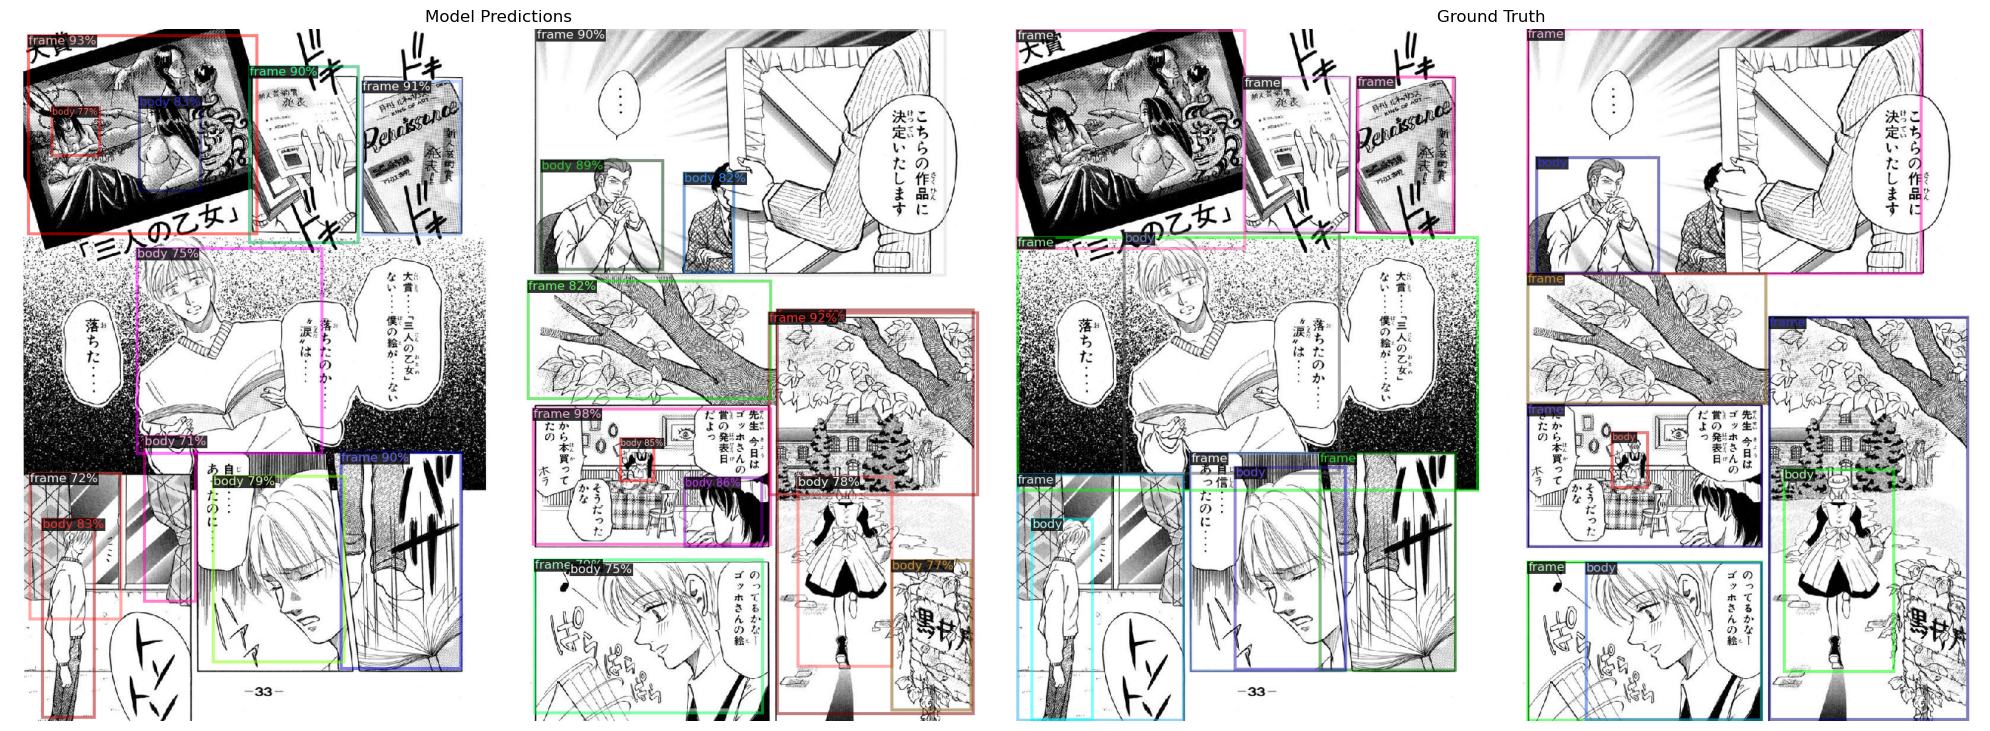

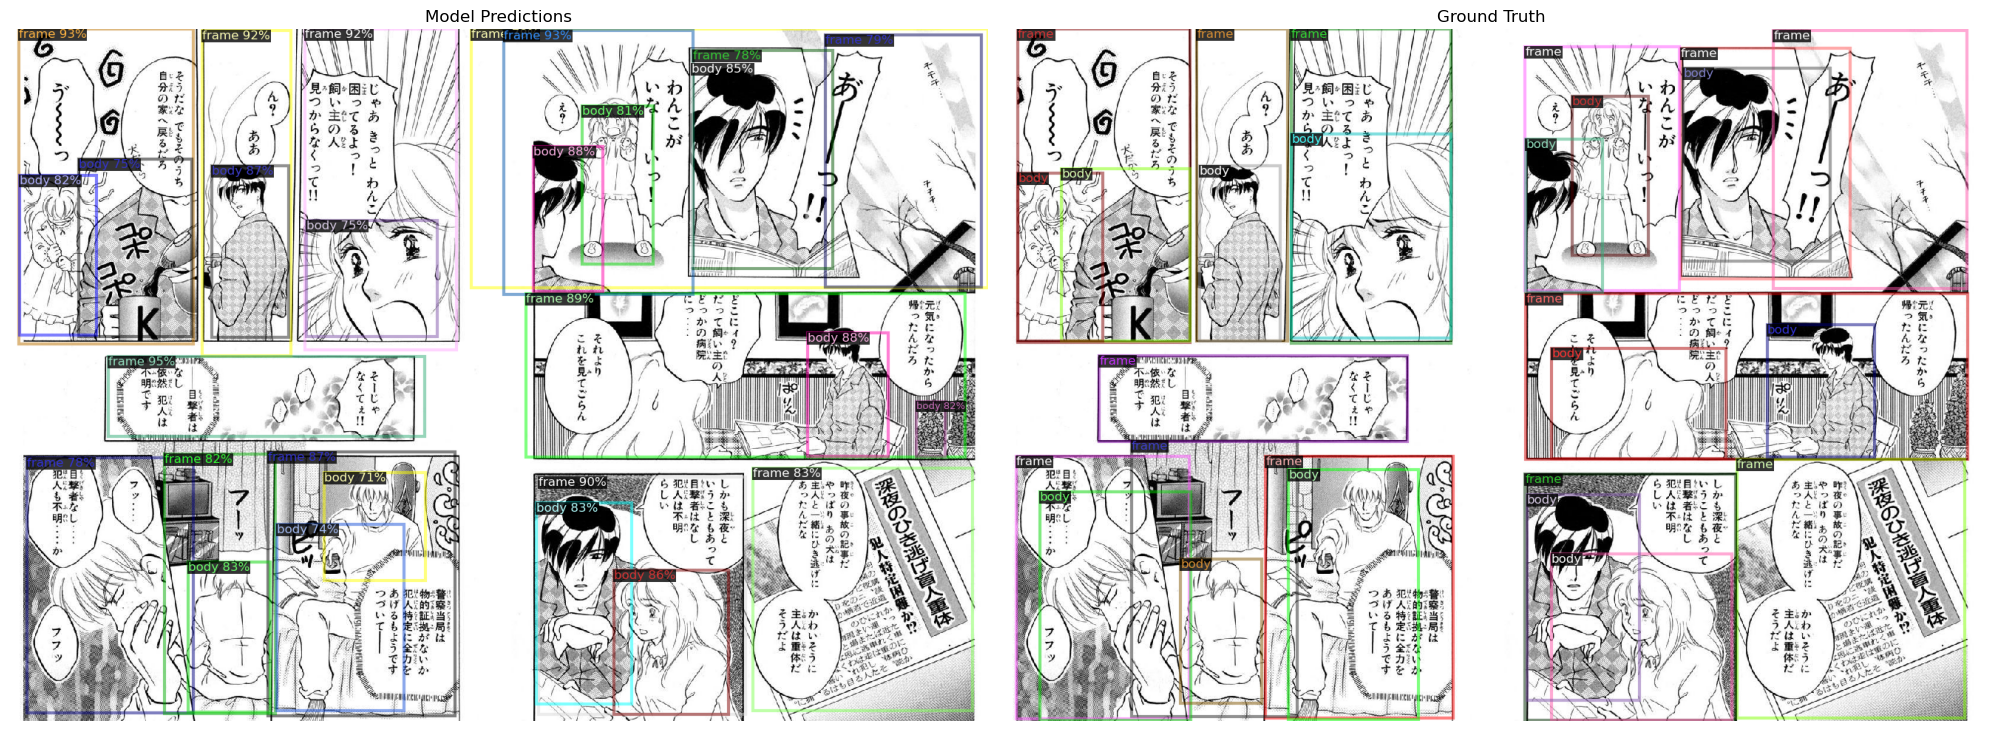

In [9]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode

# --- Setup the predictor ---
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a threshold for predictions
predictor = DefaultPredictor(cfg)

# Get the metadata and the list of data dictionaries for the validation set
val_metadata = MetadataCatalog.get("manga109_val")
dataset_dicts = DatasetCatalog.get("manga109_val")

# Randomly select a few images from the validation set to visualize
num_images_to_show = 3
for d in random.sample(dataset_dicts, num_images_to_show):    
    im = cv2.imread(d["file_name"])
    if im is None:
        print(f"Warning: Could not read image {d['file_name']}. Skipping.")
        continue

    # Make predictions
    outputs = predictor(im)

    # --- Visualize Predictions ---
    v_pred = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW # or ColorMode.IMAGE
    )
    predictions_vis = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))

    # --- Visualize Ground Truth ---
    v_gt = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.8
    )
    ground_truth_vis = v_gt.draw_dataset_dict(d)

    # --- Display side-by-side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.imshow(predictions_vis.get_image()[:, :, ::-1])
    ax1.set_title("Model Predictions")
    ax1.axis("off")

    ax2.imshow(ground_truth_vis.get_image()[:, :, ::-1])
    ax2.set_title("Ground Truth")
    ax2.axis("off")
    
    plt.tight_layout()
    plt.show()